In [20]:
import numpy as np
from itertools import chain, product
from collections import Counter
import random

# Read in Data

In [237]:
m = 5
chrom = '20'
phase_dir = '../phased'
data_dir = '../split_gen_miss'

In [56]:

# inheritance states
#
#
# for parents:
# (0, 0) -> double deletion
# (0, 1) -> deletion on parental1
# (1, 0) -> deletion on parental2
# (1, 1) -> normal
# 
# for children:
# (0, 0) -> m1p1
# (0, 1) -> m1p2
# (1, 0) -> m2p1
# (1, 1) -> m2p2
#
# for family:
# (0) -> can't model
# (1) -> we're good

if m >= 5:
	inheritance_states = np.array(list(product(*([[0, 1]]*(2*m)))), dtype=np.int8)
else:
	inheritance_states = np.array([x for x in product(*([[0, 1]]*(2*m))) if x[4]==0 and x[5]==0], dtype=np.int8)

state_to_index = dict([(tuple(x), i) for i, x in enumerate(inheritance_states)])
p = inheritance_states.shape[0]
print('inheritance states', inheritance_states.shape)

inheritance states (1024, 10)


In [57]:
# genotype (pred, obs): cost
g_cost = {
	(-1, 0): 1,
	(-1, 1): 1,
	(-1, 2): 1,
	(0, 0): 0,
	(0, 1): 1,
	(0, 2): 2,
	(1, 0): 1,
	(1, 1): 0,
	(1, 2): 1,
	(2, 0): 2,
	(2, 1): 1,
	(2, 2): 0
}


# perfect match genotypes
pm_gen_to_index = dict()
pm_gen_indices = []
for s in inheritance_states:
	anc_pos = [[-1] if s[i] == 0 else [0, 1] for i in range(4)]
	anc_variants = np.array(list(product(*anc_pos)), dtype=np.int8)
	pred_gens = np.zeros((anc_variants.shape[0], m), dtype=np.int8)

	# mom
	# deletion
	pred_gens[(anc_variants[:, 0]==-1) & (anc_variants[:, 1]==-1), 0] = -1
	pred_gens[(anc_variants[:, 0]==-1) & (anc_variants[:, 1]==0), 0] = 0
	pred_gens[(anc_variants[:, 0]==-1) & (anc_variants[:, 1]==1), 0] = 2
	pred_gens[(anc_variants[:, 0]==0) & (anc_variants[:, 1]==-1), 0] = 0
	pred_gens[(anc_variants[:, 0]==1) & (anc_variants[:, 1]==-1), 0] = 2
	# normal
	pred_gens[(anc_variants[:, 0]==0) & (anc_variants[:, 1]==0), 0] = 0
	pred_gens[(anc_variants[:, 0]==1) & (anc_variants[:, 1]==1), 0] = 2
	pred_gens[(anc_variants[:, 0]==0) & (anc_variants[:, 1]==1), 0] = 1
	pred_gens[(anc_variants[:, 0]==1) & (anc_variants[:, 1]==0), 0] = 1

	# dad
	# deletion
	pred_gens[(anc_variants[:, 2]==-1) & (anc_variants[:, 3]==-1), 1] = -1
	pred_gens[(anc_variants[:, 2]==-1) & (anc_variants[:, 3]==0), 1] = 0
	pred_gens[(anc_variants[:, 2]==-1) & (anc_variants[:, 3]==1), 1] = 2
	pred_gens[(anc_variants[:, 2]==0) & (anc_variants[:, 3]==-1), 1] = 0
	pred_gens[(anc_variants[:, 2]==1) & (anc_variants[:, 3]==-1), 1] = 2
	# normal
	pred_gens[(anc_variants[:, 2]==0) & (anc_variants[:, 3]==0), 1] = 0
	pred_gens[(anc_variants[:, 2]==1) & (anc_variants[:, 3]==1), 1] = 2
	pred_gens[(anc_variants[:, 2]==0) & (anc_variants[:, 3]==1), 1] = 1
	pred_gens[(anc_variants[:, 2]==1) & (anc_variants[:, 3]==0), 1] = 1

	# children
	for index in range(m-2):
		mat, pat = s[(4+(2*index)):(6+(2*index))]
        
		# deletion
		pred_gens[(anc_variants[:, mat]==-1) & (anc_variants[:, 2+pat]==-1), 2+index] = -1
		pred_gens[(anc_variants[:, mat]==-1) & (anc_variants[:, 2+pat]==0), 2+index] = 0
		pred_gens[(anc_variants[:, mat]==-1) & (anc_variants[:, 2+pat]==1), 2+index] = 2
		pred_gens[(anc_variants[:, mat]==0) & (anc_variants[:, 2+pat]==-1), 2+index] = 0
		pred_gens[(anc_variants[:, mat]==1) & (anc_variants[:, 2+pat]==-1), 2+index] = 2
		# normal
		pred_gens[(anc_variants[:, mat]==0) & (anc_variants[:, 2+pat]==0), 2+index] = 0
		pred_gens[(anc_variants[:, mat]==1) & (anc_variants[:, 2+pat]==1), 2+index] = 2
		pred_gens[(anc_variants[:, mat]==0) & (anc_variants[:, 2+pat]==1), 2+index] = 1
		pred_gens[(anc_variants[:, mat]==1) & (anc_variants[:, 2+pat]==0), 2+index] = 1

	unique_pred_gens = set(map(tuple, pred_gens))
	for pg in unique_pred_gens:
		if pg not in pm_gen_to_index:
			pm_gen_to_index[pg] = len(pm_gen_to_index)
	pm_gen_indices.append([pm_gen_to_index[pg] for pg in unique_pred_gens])

pm_gen = np.zeros((len(pm_gen_to_index), m), dtype=np.int8)
for pm, i in pm_gen_to_index.items():
	pm_gen[i, :] = pm
print('perfect matches', pm_gen.shape, Counter([len(v) for v in pm_gen_indices]))

genotypes = np.array(list(product(*[[0, 1, 2]]*m)), dtype=np.int8)
genotype_to_index = dict([(tuple(x), i) for i, x in enumerate(genotypes)])
q = genotypes.shape[0]
print('genotypes', genotypes.shape)

losses = np.zeros((p, q), dtype=np.int8)
already_calculated = np.zeros((q,), dtype=bool)
def calculate_loss(gen): 
	gen_index = genotype_to_index[tuple(gen)]
	if not already_calculated[gen_index]:
		s = np.zeros((len(pm_gen_to_index),), dtype=np.int8)
		for pm, i in pm_gen_to_index.items():
			s[i] = sum([g_cost[(pred, obs)] for pred, obs in zip(pm, gen)])
	    
		for i, indices in enumerate(pm_gen_indices):
			losses[i, gen_index] = np.min(s[indices])
		already_calculated[gen_index] = True
	return losses[:, gen_index]

perfect matches (328, 5) Counter({4: 384, 2: 256, 8: 256, 1: 64, 16: 48, 15: 16})
genotypes (243, 5)


In [238]:
# pull families
fam_to_individuals = dict()
with open(phase_dir + '/chr.%s.familysize.%d.families.txt' % (chrom, m), 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split()
        fam_to_individuals[pieces[0]] = pieces[1:]

In [239]:
# pull families with sequence data
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
with open(sample_file, 'r') as f:
    sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

In [240]:
from scipy import sparse
from os import listdir

# pull genotype data from .npz
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s' % chrom) in f and 'gen.npz' in f])
whole_chrom = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])
#whole_chrom = whole_chrom[:, snp_indices]

total_inds, n = whole_chrom.shape
print('chrom shape', total_inds, n)

chrom shape 4610 1707845


In [241]:
# use only "cleaned" variants - must be SNPs
coordinates = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom))
snp_positions = coordinates[:, 1]
snp_indices = coordinates[:, 2]==1

whole_chrom = whole_chrom[:, snp_indices]
snp_positions = snp_positions[snp_indices]
total_inds, n = whole_chrom.shape
print('chrom shape only SNPs', total_inds, n)

chrom shape only SNPs 4610 1567602


In [242]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}
chrom_length = chrom_lengths[chrom]

# Evaluate Fit

In [262]:
fkey, inds = random.choice(list(fam_to_individuals.items()))
#fkey = 'AU0781.AU078101.AU078102' # bad fit
#inds = fam_to_individuals[fkey]
ind_indices = [sample_id_to_index[x] for x in inds]

In [263]:
print('family', fkey)

# pull genotype data for this family
family_genotypes = whole_chrom[ind_indices, :].A

# if any family member is missing, set whole family to 0 - this has the effect of ignoring missing positions
family_genotypes[:, np.any(family_genotypes<0, axis=0)] = 0

family_whole_chrom = np.zeros((m, chrom_length), dtype=np.int8)
family_whole_chrom[:, snp_positions-1] = family_genotypes

# condense repeated genotypes
rep_indices = np.where(np.any(family_whole_chrom[:, 1:]!=family_whole_chrom[:, :-1], axis=0))[0]

family_genotypes = family_whole_chrom[:, rep_indices]
family_genotypes = np.append(family_genotypes, family_whole_chrom[:, -1][:, np.newaxis], axis=1)
print(family_genotypes.shape)
n = family_genotypes.shape[1]

family_snp_positions = np.zeros((n, 2), dtype=int)
family_snp_positions[0, 0] = 0
family_snp_positions[-1, 1] = chrom_lengths[chrom]
family_snp_positions[1:, 0] = (rep_indices+1)
family_snp_positions[:-1, 1] = (rep_indices+1)
mult_factor = family_snp_positions[:, 1] - family_snp_positions[:, 0]

family AU1305.AU1305202.AU1305201
(5, 234911)


In [264]:
# load deletions for this family
final_states = -np.ones(((m*2), n), dtype=np.int8)
with open(phase_dir + '/chr.%s.familysize.%d.phased.txt' % (chrom, m), 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0] == fkey:
            inheritance_state = [int(x) for x in pieces[1:(1+(m*2))]]
            start_pos, end_pos = [int(x) for x in pieces[(1+(m*2)):(3+(m*2))]]
            start_index, end_index = [int(x) for x in pieces[(3+(m*2)):(5+(m*2))]]
            final_states[:, start_index:(end_index+1)] = np.asarray(inheritance_state)[:, np.newaxis]
        

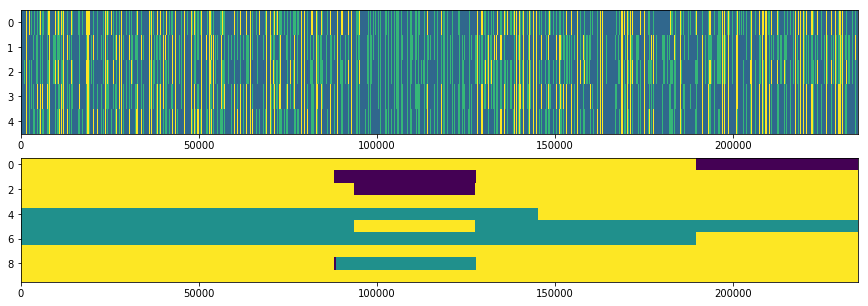

In [265]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.imshow(family_genotypes, aspect='auto', vmin=-1, vmax=2)
plt.subplot(2, 1, 2)
plt.imshow(final_states, aspect='auto', vmin=-1, vmax=1)
plt.show()

In [266]:
fit = -np.ones((n,), dtype=int)
prev_state = None
prev_state_indices = None
for j in range(n): 
    pos_gen = tuple(family_genotypes[:, j])
    loss = calculate_loss(pos_gen).astype(int)
    current_state = tuple(final_states[:, j])
    
    if current_state != prev_state:
        prev_state = current_state
        num_unknowns = len([x for x in current_state if x == -1])
        if num_unknowns>0:
            prev_state_indices = []
            for poss_itr in [iter(x) for x in product(*([[0, 1]]*num_unknowns))]:
                poss_state = tuple([x if x != -1 else next(poss_itr) for x in current_state])
                prev_state_indices.append(state_to_index[poss_state])
        else:
            prev_state_indices = [state_to_index[tuple(final_states[:, j])]]
            
    fit[j] = mult_factor[j]*np.min(loss[prev_state_indices])

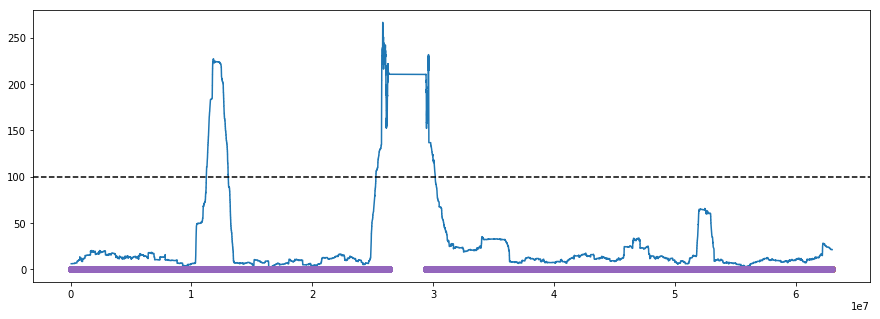

In [267]:
error_rate = .02
smooth = 5000
plt.figure(figsize=(15, 5))
c = np.convolve(fit/m, np.ones(smooth,), mode='same')
plt.plot(family_snp_positions[:, 1], c)
plt.plot(family_snp_positions[:, 1], (final_states[0, :]==0)*400, 'o')
plt.plot(family_snp_positions[:, 1], (final_states[1, :]==0)*400, 'o')
plt.plot(family_snp_positions[:, 1], (final_states[2, :]==0)*400, 'o')
plt.plot(family_snp_positions[:, 1], (final_states[3, :]==0)*400, 'o')
#plt.plot(family_snp_positions[:, 1], fit)
plt.axhline(error_rate*smooth, color='black', linestyle='--')
plt.show()

In [164]:
del_starts = np.where(((final_states[0, 1:]==0) & (final_states[0, :-1]!=0)) | ((final_states[1, 1:]==0) & (final_states[1, :-1]!=0)))[0]
del_ends = np.where(((final_states[0, 1:]!=0) & (final_states[0, :-1]==0)) | ((final_states[1, 1:]!=0) & (final_states[1, :-1]==0)))[0]


0.0963855421686747 203.08433734939717
0.0 164.82556701030921
0.0013280212483399733 1.7925630810092958
0.008557457212713936 4.211735941320293


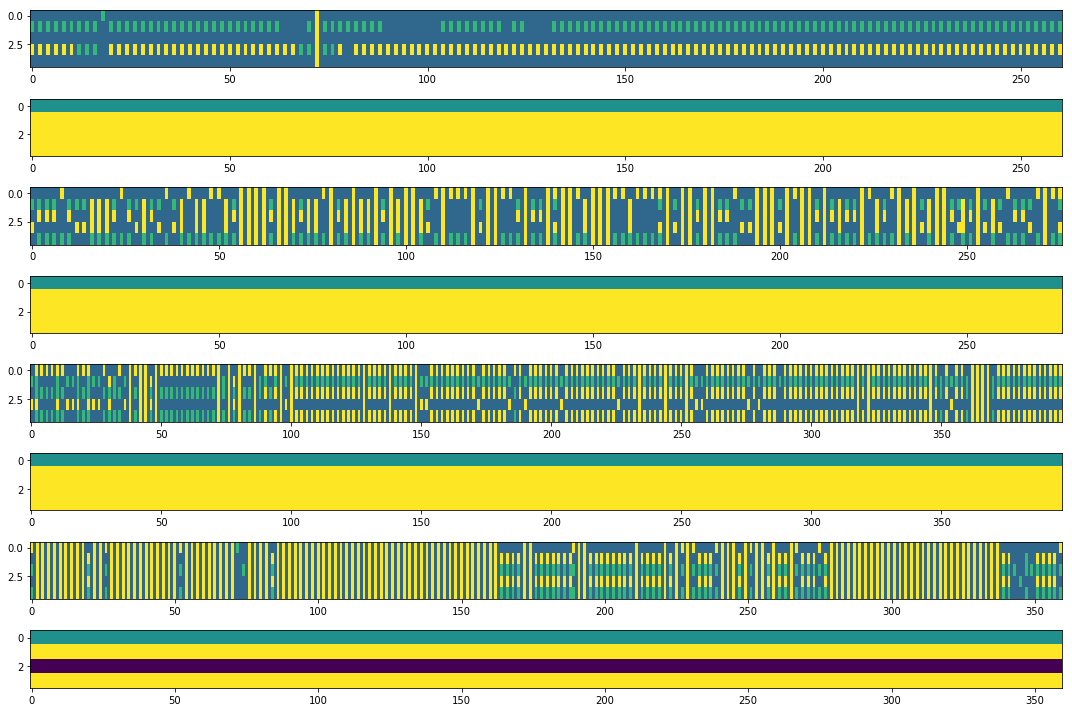

In [174]:
num_dels = del_starts.shape[0]

plt.figure(figsize=(15, 10))

for i, (start, end) in enumerate(zip(del_starts, del_ends)):
    delcost = np.sum(fit[(start+1):(end+1)])/np.sum(family_genotypes[:, (start+1):(end+1)]>0)
    ccost = np.sum(c[(start+1):(end+1)])/np.sum(family_genotypes[:, (start+1):(end+1)]>0)
    print(delcost, ccost)
    
    plt.subplot(2*num_dels, 1, 2*i+1)
    plt.imshow(family_genotypes[:, (start+1):(end+1)], aspect='auto', vmin=-1, vmax=2)
    plt.subplot(2*num_dels, 1, 2*i+2)
    plt.imshow(final_states[:4, (start+1):(end+1)], aspect='auto', vmin=-1, vmax=1)
    
plt.tight_layout()
plt.show()

In [243]:
dcosts = []
diffcosts = []
for fkey, inds in fam_to_individuals.items(): 
    print('family', fkey)
    
    ind_indices = [sample_id_to_index[x] for x in inds]
    
    # pull genotype data for this family
    family_genotypes = whole_chrom[ind_indices, :].A

    # if any family member is missing, set whole family to 0 - this has the effect of ignoring missing positions
    family_genotypes[:, np.any(family_genotypes<0, axis=0)] = 0

    family_whole_chrom = np.zeros((m, chrom_length), dtype=np.int8)
    family_whole_chrom[:, snp_positions-1] = family_genotypes

    # condense repeated genotypes
    rep_indices = np.where(np.any(family_whole_chrom[:, 1:]!=family_whole_chrom[:, :-1], axis=0))[0]

    family_genotypes = family_whole_chrom[:, rep_indices]
    family_genotypes = np.append(family_genotypes, family_whole_chrom[:, -1][:, np.newaxis], axis=1)
    print(family_genotypes.shape)
    n = family_genotypes.shape[1]

    family_snp_positions = np.zeros((n, 2), dtype=int)
    family_snp_positions[0, 0] = 0
    family_snp_positions[-1, 1] = chrom_lengths[chrom]
    family_snp_positions[1:, 0] = (rep_indices+1)
    family_snp_positions[:-1, 1] = (rep_indices+1)
    mult_factor = family_snp_positions[:, 1] - family_snp_positions[:, 0]
    
    # load deletions for this family
    final_states = -np.ones(((m*2), n), dtype=np.int8)
    with open(phase_dir + '/chr.%s.familysize.%d.phased.txt' % (chrom, m), 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if pieces[0] == fkey:
                inheritance_state = [int(x) for x in pieces[1:(1+(m*2))]]
                start_pos, end_pos = [int(x) for x in pieces[(1+(m*2)):(3+(m*2))]]
                start_index, end_index = [int(x) for x in pieces[(3+(m*2)):(5+(m*2))]]
                final_states[:, start_index:(end_index+1)] = np.asarray(inheritance_state)[:, np.newaxis]
        
    for i in range(4):
        del_starts = np.where((final_states[i, 1:]==0) & (final_states[i, :-1]!=0))[0]
        del_ends = np.where((final_states[i, 1:]!=0) & (final_states[i, :-1]==0))[0]

        for i, (start, end) in enumerate(zip(del_starts, del_ends)):
            fit = -np.ones((end-start,), dtype=int)
            no_del_fit = -np.ones((end-start,), dtype=int)
            prev_state = None
            prev_state_indices = None
            no_del_prev_state_indices = None
            for j in range(end-start): 
                pos_gen = tuple(family_genotypes[:, start+1+j])
                loss = calculate_loss(pos_gen).astype(int)
                current_state = tuple(final_states[:, start+1+j])

                if current_state != prev_state:
                    prev_state = current_state
                    no_del_state = tuple([1 if x==0 else x for x in current_state[:4]] + list(current_state[4:]))
                    print(prev_state)
                    num_unknowns = len([x for x in current_state if x == -1])
                    if num_unknowns>0:
                        prev_state_indices, no_del_prev_state_indices = [], []
                        for poss_itr in [iter(x) for x in product(*([[0, 1]]*num_unknowns))]:
                            poss_state = tuple([x if x != -1 else next(poss_itr) for x in current_state])
                            prev_state_indices.append(state_to_index[poss_state])
                        for poss_itr in [iter(x) for x in product(*([[0, 1]]*num_unknowns))]:
                            no_del_poss_state = tuple([x if x != -1 else next(poss_itr) for x in no_del_state])
                            no_del_prev_state_indices.append(state_to_index[no_del_poss_state])
                    else:
                        prev_state_indices = [state_to_index[current_state]]
                        no_del_prev_state_indices = [state_to_index[no_del_state]]

                fit[j] = mult_factor[start+1+j]*np.min(loss[prev_state_indices])
                no_del_fit[j] = mult_factor[start+1+j]*np.min(loss[no_del_prev_state_indices])
            dcosts.append(np.sum(fit)/np.sum(family_genotypes[:, (start+1):(end+1)]>0))
            diffcosts.append(np.sum(no_del_fit)/np.sum(family_genotypes[:, (start+1):(end+1)]>0))

family AU0021.AU002101.AU002102
(5, 224702)
family AU0022.AU002201.AU002202
(5, 226652)
family AU0028.AU002801.AU002802
(5, 225559)
(1, 1, 0, 1, 1, 1, 0, 1, 1, 0)
family AU0037.AU003701.AU003702
(5, 222548)
family AU0041.AU004101.AU004102
(5, 229501)
family AU0043.AU004301.AU004302
(5, 217379)
family AU0063.AU006301.AU006302
(5, 226013)
family AU0084.AU008401.AU008402
(5, 225201)
family AU0109.AU010901.AU010902
(5, 231160)
family AU0115.AU011501.AU011502
(5, 231091)
family AU0123.AU012301.AU012302
(5, 225040)
family AU0127.AU012701.AU012702
(5, 224963)
family AU0145.AU014501.AU014502
(5, 227311)
family AU0148.AU014801.AU014802
(5, 222949)
family AU0167.AU016701.AU016702
(5, 229805)
family AU0169.AU016901.AU016902
(5, 225695)
family AU0175.AU017501.AU017502
(5, 227298)
family AU0179.AU017901.AU017902
(5, 229214)
family AU0188.AU018801.AU018802
(5, 226652)
family AU0190.AU019001.AU019002
(5, 229770)
family AU0196.AU019601.AU019602
(5, 225514)
family AU0199.AU019901.AU019902
(5, 231488)
f

(-1, 1, 1, 0, 1, 0, 1, 1, 1, 0)
(-1, 1, 1, 0, 1, 0, 1, 1, 1, 0)
(-1, 1, 1, 0, 1, 0, 1, 1, 1, 0)
(-1, 1, 1, 0, 1, 0, 1, 1, 1, 0)
family AU0918.AU0918202.AU0918201
(5, 231358)
family AU0930.AU0930101.AU0930102
(5, 249363)
family AU0947.AU0947202.AU0947201


KeyboardInterrupt: 

family AU0836.AU083601.AU083602
(5, 227492)
family AU1292.AU1292202.AU1292201
(5, 226523)
family AU3311.AU3311202.AU3311201
(5, 226287)
family AU0871.AU0871202.AU0871201
(5, 287254)
family AU0022.AU002201.AU002202
(5, 226652)
family AU0862.AU0862202.AU0862201
(5, 234357)
family AU3912.AU3912202.AU3912201
(5, 228227)
family AU0028.AU002801.AU002802
(5, 225559)
family AU2793.AU2793202.AU2793201
(5, 226099)
family AU0273.AU027301.AU027302
(5, 224306)
family AU3263.AU3263202.AU3263201
(5, 228539)
family AU0777.AU077701.AU077702
(5, 230540)
family AU0777.AU077701.AU077702
(5, 230540)
family AU1684.AU1684202.AU1684201
(5, 232414)
family AU2777.AU2777202.AU2777201
(5, 225116)
family AU1190.AU1190202.AU1190201
(5, 230487)
family AU1585.AU1585202.AU1585201
(5, 224200)
family AU0808.AU080801.AU080802
(5, 229331)
family AU1030.AU1030202.AU1030201
(5, 223928)
family AU1746.AU1746202.AU1746201
(5, 228402)


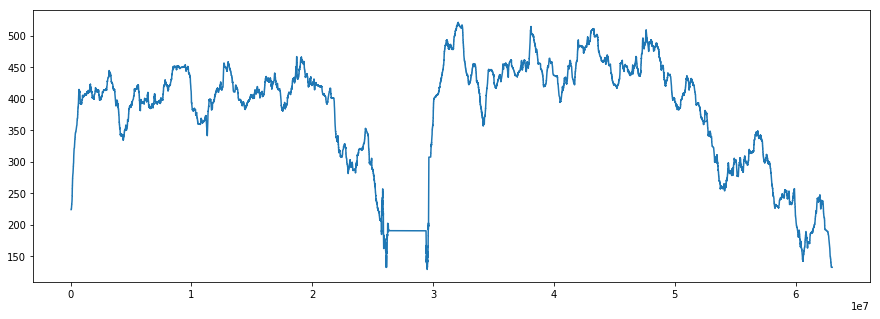

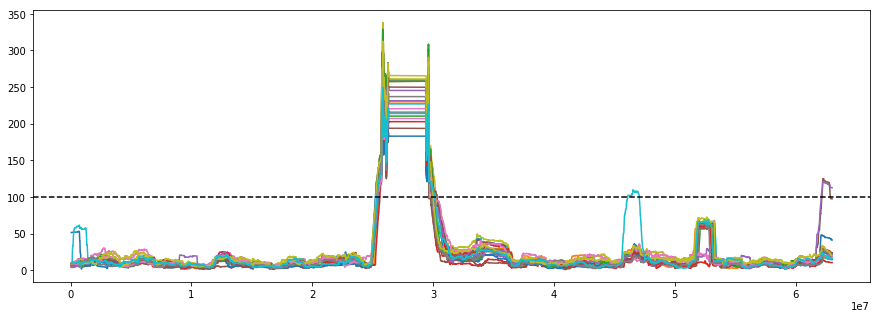

In [269]:
error_rate = .02
smooth = 5000
plt.figure(figsize=(15, 5))

for _ in range(20): 
    fkey, inds = random.choice(list(fam_to_individuals.items()))
    print('family', fkey)
    
    ind_indices = [sample_id_to_index[x] for x in inds]
    
    # pull genotype data for this family
    family_genotypes = whole_chrom[ind_indices, :].A

    # if any family member is missing, set whole family to 0 - this has the effect of ignoring missing positions
    family_genotypes[:, np.any(family_genotypes<0, axis=0)] = 0

    family_whole_chrom = np.zeros((m, chrom_length), dtype=np.int8)
    family_whole_chrom[:, snp_positions-1] = family_genotypes

    # condense repeated genotypes
    rep_indices = np.where(np.any(family_whole_chrom[:, 1:]!=family_whole_chrom[:, :-1], axis=0))[0]

    family_genotypes = family_whole_chrom[:, rep_indices]
    family_genotypes = np.append(family_genotypes, family_whole_chrom[:, -1][:, np.newaxis], axis=1)
    print(family_genotypes.shape)
    n = family_genotypes.shape[1]

    family_snp_positions = np.zeros((n, 2), dtype=int)
    family_snp_positions[0, 0] = 0
    family_snp_positions[-1, 1] = chrom_lengths[chrom]
    family_snp_positions[1:, 0] = (rep_indices+1)
    family_snp_positions[:-1, 1] = (rep_indices+1)
    mult_factor = family_snp_positions[:, 1] - family_snp_positions[:, 0]
    
    # load deletions for this family
    final_states = -np.ones(((m*2), n), dtype=np.int8)
    with open(phase_dir + '/chr.%s.familysize.%d.phased.txt' % (chrom, m), 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if pieces[0] == fkey:
                inheritance_state = [int(x) for x in pieces[1:(1+(m*2))]]
                start_pos, end_pos = [int(x) for x in pieces[(1+(m*2)):(3+(m*2))]]
                start_index, end_index = [int(x) for x in pieces[(3+(m*2)):(5+(m*2))]]
                final_states[:, start_index:(end_index+1)] = np.asarray(inheritance_state)[:, np.newaxis]

    
    fit = -np.ones((n,), dtype=int)
    prev_state = None
    prev_state_indices = None
    for j in range(n): 
        pos_gen = tuple(family_genotypes[:, j])
        loss = calculate_loss(pos_gen).astype(int)
        current_state = tuple(final_states[:, j])

        if current_state != prev_state:
            prev_state = current_state
            num_unknowns = len([x for x in current_state if x == -1])
            if num_unknowns>0:
                prev_state_indices = []
                for poss_itr in [iter(x) for x in product(*([[0, 1]]*num_unknowns))]:
                    poss_state = tuple([x if x != -1 else next(poss_itr) for x in current_state])
                    prev_state_indices.append(state_to_index[poss_state])
            else:
                prev_state_indices = [state_to_index[tuple(final_states[:, j])]]

        fit[j] = mult_factor[j]*np.min(loss[prev_state_indices])


    c = np.convolve(fit/m, np.ones(smooth,), mode='same')
    plt.plot(family_snp_positions[:, 1], np.convolve(fit/m, np.ones(smooth,), mode='same'))

plt.axhline(error_rate*smooth, color='black', linestyle='--')
plt.show()

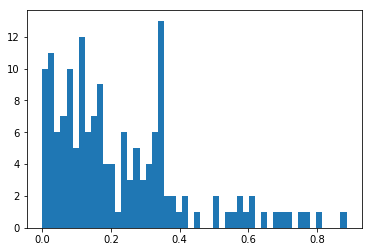

In [244]:
plt.hist(dcosts, bins=50)
plt.show()

min 0.0 max 88.64864864864866 avg 0.2245219305059572 median 0.16584564860426929


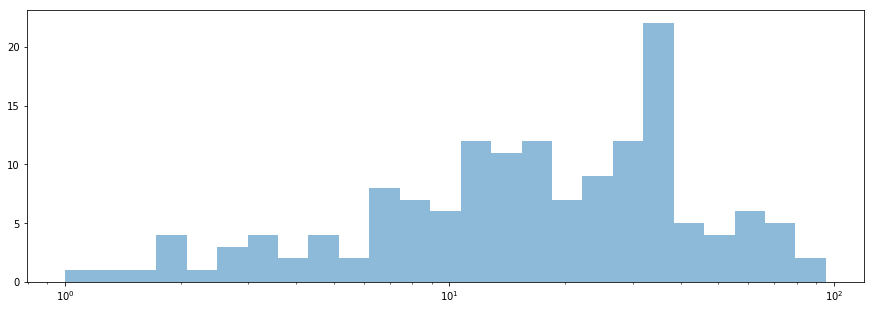

In [247]:
import math

plt.figure(figsize=(15, 5))
base = 1.2

max_length = 100*max(dcosts) 
min_length = 100*min(dcosts) 
mean_length = np.mean(100*dcosts)
median_length = np.median(100*dcosts)
print('min', min_length, 'max', max_length, 'avg', mean_length, 'median', median_length)

plt.gca().set_xscale("log")

plt.hist(100*np.asarray(dcosts), bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)

plt.show()

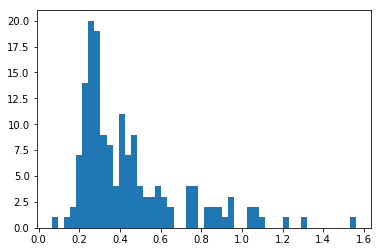

In [248]:
plt.hist(diffcosts, bins=50)
plt.show()